<a href="https://colab.research.google.com/github/dancher00/dls/blob/main/hw_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

for split in ['train', 'test']:
    for example in dataset[split]:
        text = example['text']
        sents = sent_tokenize(text)
        for sent in sents:
            words = word_tokenize(sent.lower())
            if len(words) < word_threshold:
                sentences.append(sent.lower())

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 394365


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
for sentence in sentences:
    tokens = word_tokenize(sentence)
    words.update(tokens)


In [10]:
print("Всего уникальных слов:", len(words))

Всего уникальных слов: 98265


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
vocab = set()
vocab_size = 40000

vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

# Наполнение словаря

most_common = words.most_common(vocab_size)
for word, count in most_common:
    vocab.add(word)

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []

        tokenized_sentence.append(self.bos_id)

        sentence = self.data[idx]
        words = word_tokenize(sentence)

        for word in words:
            if word in word2ind:
                tokenized_sentence.append(word2ind[word])
            else:
                tokenized_sentence.append(self.unk_id)

        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [18]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:

            logits = model(batch['input_ids'])
            logits = logits.reshape(-1, logits.size(-1))

            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [19]:
def train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    eval_perplexities = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            logits = logits.reshape(-1, logits.size(-1))

            loss = criterion(logits, batch['target_ids'].flatten())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_loss)

        eval_perplexity = evaluate(model, criterion, eval_dataloader)
        eval_perplexities.append(eval_perplexity)

        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Eval Perplexity = {eval_perplexity:.4f}')

    return train_losses, eval_perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [20]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_batch)

        lstm_out, _ = self.lstm(embedded)

        lstm_out = self.dropout(lstm_out)

        logits = self.fc(lstm_out)

        return logits

In [21]:
# Обучите модель здесь

model1 = LanguageModel(
    vocab_size=len(vocab),
    embedding_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

print("Эксперимент 1: LSTM с 2 слоями, hidden_dim=512, embedding_dim=256")
train_losses1, eval_perplexities1 = train_model(
    model1,
    train_dataloader,
    eval_dataloader,
    criterion,
    optimizer,
    num_epochs=5
)

test_perplexity1 = evaluate(model1, criterion, test_dataloader)
print(f'\nТестовая перплексия модели 1: {test_perplexity1:.4f}')

Эксперимент 1: LSTM с 2 слоями, hidden_dim=512, embedding_dim=256


Epoch 1/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 1: Loss = 5.3483, Eval Perplexity = 115.4929


Epoch 2/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 2: Loss = 4.6933, Eval Perplexity = 86.1920


Epoch 3/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 3: Loss = 4.4856, Eval Perplexity = 73.1864


Epoch 4/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 4: Loss = 4.3502, Eval Perplexity = 65.2102


Epoch 5/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 5: Loss = 4.2495, Eval Perplexity = 59.8827

Тестовая перплексия модели 1: 59.5425


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [22]:
# Проведите второй эксперимент

class LanguageModelGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=768, num_layers=3, dropout=0.4):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU вместо LSTM
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)


        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim // 2, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_batch)
        gru_out, _ = self.gru(embedded)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)

        out = self.fc1(gru_out)
        out = self.relu(out)
        out = self.dropout(out)
        logits = self.fc2(out)

        return logits

model2 = LanguageModelGRU(
    vocab_size=len(vocab),
    embedding_dim=256,
    hidden_dim=768,
    num_layers=3,
    dropout=0.4
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005)

print("Эксперимент 2: GRU с 3 слоями, hidden_dim=768, LayerNorm, 2 FC слоя")
train_losses2, eval_perplexities2 = train_model(
    model2,
    train_dataloader,
    eval_dataloader,
    criterion,
    optimizer,
    num_epochs=5
)

test_perplexity2 = evaluate(model2, criterion, test_dataloader)
print(f'\nТестовая перплексия модели 2: {test_perplexity2:.4f}')

Эксперимент 2: GRU с 3 слоями, hidden_dim=768, LayerNorm, 2 FC слоя


Epoch 1/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 1: Loss = 5.2426, Eval Perplexity = 115.9861


Epoch 2/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 2: Loss = 4.8151, Eval Perplexity = 94.6245


Epoch 3/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 3: Loss = 4.6659, Eval Perplexity = 84.0948


Epoch 4/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 4: Loss = 4.5729, Eval Perplexity = 78.0465


Epoch 5/5:   0%|          | 0/2465 [00:00<?, ?it/s]

Epoch 5: Loss = 4.5058, Eval Perplexity = 73.8852

Тестовая перплексия модели 2: 73.4926


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

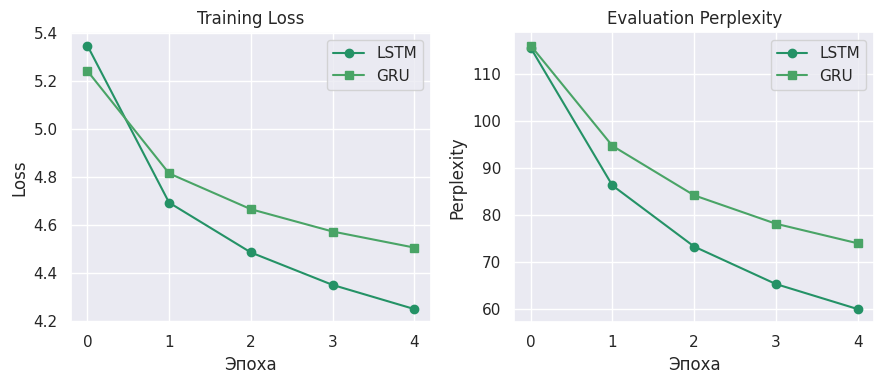


Эксперимент 1: LSTM модель
Архитектура: 2-слойный LSTM
Тестовая перплексия: 59.5425

Эксперимент 2: GRU модель с улучшениями
Архитектура: 3-слойный GRU + LayerNorm + 2 FC слоя
Тестовая перплексия: 73.4926


In [30]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='LSTM', marker='o')
plt.plot(train_losses2, label='GRU', marker='s')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eval_perplexities1, label='LSTM', marker='o')
plt.plot(eval_perplexities2, label='GRU', marker='s')
plt.xlabel('Эпоха')
plt.ylabel('Perplexity')
plt.title('Evaluation Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nЭксперимент 1: LSTM модель")
print("Архитектура: 2-слойный LSTM")

print(f"Тестовая перплексия: {test_perplexity1:.4f}")

print("\nЭксперимент 2: GRU модель с улучшениями")
print("Архитектура: 3-слойный GRU + LayerNorm + 2 FC слоя")
print(f"Тестовая перплексия: {test_perplexity2:.4f}")


Первая модель продемонстрировала лучший результат.

1. Анализ:
   - Увеличение количества слоев (с 2 до 3) не улучшило качество
   - Больший размер скрытого состояния (768 vs 512) также не дал преимущества
   - Добавление LayerNorm и дополнительного FC слоя не привело к снижению перплексии
   - Более низкий learning rate мог замедлить сходимость модели

2. Возможные направления улучшения:
   - Увеличить количество эпох
   - Экспериментировать с размером словаря и длиной предложений
   - Попробовать другие комбинации гиперпараметров

Вывод: для данной задачи оптимальной оказалась более простая архитектура
с 2-слойным LSTM
